In [1]:
# !pip install category_encoders
# !pip install colorama
# !pip install imbalanced-learn
# !pip install hyperopt
# !pip install optuna

## Import

In [2]:
from datetime import datetime
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    Perceptron,
)
from sklearn.metrics import (
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from src import custom_dataframe
from src.chainable_plt import ChainablePlt
from src.clean_categorical_columns import (
    clean_field_of_study,
    clean_location,
    clean_university_names,
)
from src.create_evaluate_pipeline import (
    display_top_models,
    evaluate_parameter_grid,
    predict_and_score,
    print_scores,
)
from src.helpers import load_model_params
from src.feature_engineering import add_partner_columns, create_equality_features
from src.imputers import impute_columns_by_gender, questionnaire_impute_0

In [4]:
pd.set_option('display.max_colwidth', 500) 
pd.set_option('display.max_info_columns', 500) 
pd.set_option('display.max_rows', 100)

In [5]:
cplt = ChainablePlt(plt)
RANDOM_STATE = 42

# Predicting Dating Match Success Using Machine Learning

## ❤️TODO

- delete all unneeded files and functions from the FS
- abstract
- add section numbers
- save final model
- add check for duplicate rows in teh beginning
- unfreeze all frozen cells
- feature selection

- link to functions
- custom_dataframe
- OneHot (or other) encoder or get_dummies, instead of eq, diff,
- find all plt and convert them to cplt
- docstrings

- the functions in clean-origin_columns.py can be made simpler, add docstrings
- date, date_o, do_out, goi_out_o - try ordinal encoding because thats how we normalized the values
- display_top_models better printing
- Evaluating combination 1/3 - improve
- find outliers, one-class SVM, RANSAC (3)
- desribe what didn't work: SMOTE

In [6]:
# ❤️MII за сега това е най-добрият модел:

xgb_param_grid = {
    "model": [XGBClassifier(objective='binary:logistic', random_state=RANDOM_STATE)],
    "model__booster": ["gbtree"],  # Type of booster to use

    # Tree Booster Parameters (used in gbtree and dart boosters)
    "model__eta":               [0.2],     # [0.01, 0.05, 0.1, 0.2, 0.3],  # Learning rate (slower = more robust)
    "model__max_depth":         [10],      # default=6
    "model__min_child_weight":  [5],       # default=1
    "model__gamma":             [0],       # default=0
    "model__subsample":         [1.0],     # default: 1
    "model__colsample_bytree":  [1.0],     # default=1
    "model__colsample_bylevel": [1.0],     # default=1
    "model__colsample_bynode":  [1.0],     # default=1
    "model__lambda":            [1],       # default=1, L2 regularization term on weights
    "model__alpha":             [0],       # default=0, L1 regularization term on weights
    "model__tree_method":       ["hist"],  # Method for building trees
    "model__scale_pos_weight":  [1],  # default=1, Balance for positive classes
    "model__objective":         ["binary:logistic"],  # Loss function for classification
    "model__n_estimators":      [100]  # Number of boosting rounds
}

In [7]:
# ❤️MII DELETEME!
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

## Purpose of the project

The goal of this project is to create a machine learning model for a dating application that can predict with which users a newly registered user will be a good match. When users sign up for the dating app, they will complete a survey answering questions about their demographics, location, interests, and what they value in a potential partner. The machine learning model developed using this speed dating dataset will then be able to analyze the user's survey responses and predict which other users on the app would be a good match for them. By uncovering the key factors that influence successful matches from the speed dating experiment data, the model can be applied to provide personalized match recommendations for users of the dating application.

## Load the data and a quick look

In [8]:
df = pd.read_csv("dating_data/02_Speed Dating Data.csv", encoding='ISO-8859-1')

In [9]:
df.shape

(8378, 195)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 195 columns):
 #    Column    Non-Null Count  Dtype  
---   ------    --------------  -----  
 0    iid       8378 non-null   int64  
 1    id        8377 non-null   float64
 2    gender    8378 non-null   int64  
 3    idg       8378 non-null   int64  
 4    condtn    8378 non-null   int64  
 5    wave      8378 non-null   int64  
 6    round     8378 non-null   int64  
 7    position  8378 non-null   int64  
 8    positin1  6532 non-null   float64
 9    order     8378 non-null   int64  
 10   partner   8378 non-null   int64  
 11   pid       8368 non-null   float64
 12   match     8378 non-null   int64  
 13   int_corr  8220 non-null   float64
 14   samerace  8378 non-null   int64  
 15   age_o     8274 non-null   float64
 16   race_o    8305 non-null   float64
 17   pf_o_att  8289 non-null   float64
 18   pf_o_sin  8289 non-null   float64
 19   pf_o_int  8289 non-null   float64
 20   pf_o_f

In [11]:
print("A quick look at the columns: \n", str(df.columns.to_list()))

A quick look at the columns: 
 ['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position', 'positin1', 'order', 'partner', 'pid', 'match', 'int_corr', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'age', 'field', 'field_cd', 'undergra', 'mn_sat', 'tuition', 'race', 'imprace', 'imprelig', 'from', 'zipcode', 'income', 'goal', 'date', 'go_out', 'career', 'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'int

In [12]:
pd.set_option('display.max_rows', 200)
df.isna().sum()

iid            0
id             1
gender         0
idg            0
condtn         0
wave           0
round          0
position       0
positin1    1846
order          0
partner        0
pid           10
match          0
int_corr     158
samerace       0
age_o        104
race_o        73
pf_o_att      89
pf_o_sin      89
pf_o_int      89
pf_o_fun      98
pf_o_amb     107
pf_o_sha     129
dec_o          0
attr_o       212
sinc_o       287
intel_o      306
fun_o        360
amb_o        722
shar_o      1076
like_o       250
prob_o       318
met_o        385
age           95
field         63
field_cd      82
undergra    3464
mn_sat      5245
tuition     4795
race          63
imprace       79
imprelig      79
from          79
zipcode     1064
income      4099
goal          79
date          97
go_out        79
career        89
career_c     138
sports        79
tvsports      79
exercise      79
dining        79
museums       79
art           79
hiking        79
gaming        79
clubbing      

In [13]:
pd.set_option('display.max_rows', 100)

### The data at a glance

We have a dataset of 8378 rows, 195 columns. Most of the features are numerical but there are some of type object.

Some feature names are self explanatory but most have some nomenclature that needs investigation.

There are features with 75% missing values. 

## Description of the data

### Dataset Overview

This dataset was compiled by Columbia Business School professors Ray Fisman and Sheena Iyengar between 2002-2004 for their research paper ["Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment"](http://www.stat.columbia.edu/~gelman/stuff_for_blog/sheena.pdf) (published in The Quarterly Journal of Economics, 2006 <a href="#ref1">[1]</a>. The experiment provides unique insights into modern dating behavior and mate selection preferences. The dataset and its companion key file live [here](http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/) <a href="#ref2">[2]</a>. 

### Data Collection Methodology

The participants attended experimental speed dating events where they had four-minute "first dates" with other participants of the opposite sex. After each date, participants indicated whether they would like to see their date again. Participants rated their dates on six key attributes:
  1. Attractiveness
  2. Sincerity
  3. Intelligence
  4. Fun
  5. Ambition
  6. Shared Interests

### Dataset Features

The dataset contains 195 features, including:

#### Demographic Information

- Age-related features (age, age_o, d_age)
- Field of study/work
- Race and racial preferences
- Wave (event identifier)

#### Personal Attributes

- Self-perception ratings
- Dating habits
- Lifestyle information
- Interest-related features (shopping, music, etc.)

#### Partner Preferences

- Expected partner attributes
- Partner ratings
- Importance weights for different characteristics
- Match decisions

### Dataset values

Most of the features are numerical, capturing preferences on a scale from 1 to 10. Additionally, some preferences were recorded by asking participants to allocate 100 points among different options. A few features are categorical, for example:

**Race:**
- 1: Black/African American  
- 2: European/Caucasian-American  
- 3: Latino/Hispanic American  
- 4: Asian/Pacific Islander/Asian-American  
- 5: Native American  
- 6: Other  

**How frequently do you go on dates?**
- 1: Several times a week  
- 2: Twice a week  
- 3: Once a week  
- 4: Twice a month  
- 5: Once a month  
- 6: Several times a year  
- 7: Almost never    

## Getting to know the feature names and what they represent

The data key file explains that the data was collected at different time points. First, the participants completed an initial survey (at Time 1). Then, during the event, they filled out a scorecard (with features ending in "_s"). After the event, they completed two additional surveys (at Time 2 and Time 3). 

For this project, we only need the data that was collected at Time 1.

### Features describing the event

<table border="1" style="float: left;">
    <thead>
        <tr>
            <th>pertains to the subject</th>
            <th>pertains to the partner</th>
            <th>meaning of the feature</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>iid</td>
            <td>pid</td>
            <td>Unique identifier of subject/partner</td>
        </tr>
        <tr><td>id</td><td></td><td>subject number within wave</td></tr>
        <tr><td>gender</td><td></td><td>Female=0, Male=1</td></tr>
        <tr><td>idg</td><td></td><td>subject number within gender, group(id gender)</td></tr>
        <tr><td>condtn</td><td></td><td>1=limited choice, 2=extensive choice</td></tr>
        <tr><td>wave</td><td></td><td>see additional info</td></tr>
        <tr><td>round</td><td></td><td>number of people that met in wave</td></tr>
        <tr><td>position</td><td></td><td>station number where met partner</td></tr>
        <tr><td>positin1</td><td></td><td>station number where started</td></tr>
        <tr><td>order</td><td></td><td>the number of date that night when met partner</td></tr>
        <tr><td></td><td>partner</td><td>partner’s id number the night of event (check whether exists)</td></tr>
        <tr><td>match</td><td></td><td>1=yes, 0=no</td></tr>
        <tr><td>int_corr</td><td></td><td>correlation between participant’s and partner’s ratings of interests in Time 1</td></tr>
        <tr><td>samerace</td><td></td><td>participant and the partner were the same race. 1=yes, 0=no</td></tr>
        <tr><td>exphappy</td><td></td><td>How happy do you expect to be with the people you meet during the speed-dating event? (1-10)</td></tr>
        <tr><td>expnum</td><td></td><td>Out of the 20 people you will meet, how many do you expect will be interested in dating you?</td></tr>
    </tbody>
</table>

### Signup survey (Time 1)

<table border="1" style="float: left;">
    <thead>
        <tr>
            <th>pertains to the subject</th>
            <th>pertains to the partner</th>
            <th>meaning of the feature</th>
        </tr>
    </thead>
    <tbody>
<tr><td></td><td></td><td><b><br>Bio</b>                                                                                      </td></tr>
<tr><td>age        </td><td>age_o</td><td>Age of participant                                                                       </td></tr>    
<tr><td>race       </td><td>race_o</td><td>Race (category 1-6)                                                                      </td></tr>                                  
<tr><td>field	   </td><td></td><td>Field of study                                                                           </td></tr>       
<tr><td>field_cd   </td><td></td><td>field coded (1-18, see details)                                                          </td></tr>                                           
<tr><td>undergra   </td><td></td><td>school attended for undergraduate degree                                                 </td></tr>                                            
<tr><td>mn_sat 	   </td><td></td><td>Median SAT score for the undergraduate institution where attended.                       </td></tr>                  
<tr><td>tuition    </td><td></td><td>Tuition listed for each response to undergrad                                            </td></tr>                                       
<tr><td>imprace    </td><td></td><td>How important is it to you that your date be of the same racial/ethnic background? (1-10)</td></tr>
<tr><td>imprelig   </td><td></td><td>How important is it to you that your date be of the same religious background? (1-10)    </td></tr>  
<tr><td>from       </td><td></td><td>Where are you from originally?                             </td></tr>                             
<tr><td>zipcode    </td><td></td><td>What was the zip code of the area where you grew up?       </td></tr>                                   
<tr><td>income     </td><td></td><td>Median household income based on zipcode                   </td></tr>                                              
<tr><td>goal       </td><td></td><td>What is your primary goal in participating in this event?  </td></tr>                             
<tr><td>date       </td><td></td><td>In general, how frequently do you go on dates?             </td></tr>                                      
<tr><td>go_out     </td><td></td><td>How often do you go out (not necessarily on dates)?        </td></tr>                                 
<tr><td>career     </td><td></td><td>What is your intended career?                              </td></tr>                                                       
<tr><td>career_c   </td><td></td><td>Intended career coded                                      </td></tr>                                                                  
<tr><td></td><td></td><td><b><br>How interested are you in this? (1-10)?</b></td></tr>
<tr><td>sports     </td><td></td><td>Playing sports/ athletics   </td></tr>                                 
<tr><td>tvsports   </td><td></td><td>Watching sports             </td></tr>                                          
<tr><td>exercise   </td><td></td><td>Body building/exercising    </td></tr>                                
<tr><td>dining     </td><td></td><td>Dining out                  </td></tr>                                  
<tr><td>museums    </td><td></td><td>Museums/galleries           </td></tr>                                  
<tr><td>art        </td><td></td><td>Art                         </td></tr>                                  
<tr><td>hiking     </td><td></td><td>Hiking/camping              </td></tr>                                  
<tr><td>gaming     </td><td></td><td>Gaming                      </td></tr>                                     
<tr><td>clubbing   </td><td></td><td>Dancing/clubbing            </td></tr>                                   
<tr><td>reading    </td><td></td><td>Reading                     </td></tr>                                    
<tr><td>tv         </td><td></td><td>Watching TV                 </td></tr>                                          
<tr><td>theater    </td><td></td><td>Theater                     </td></tr>                                           
<tr><td>movies     </td><td></td><td>Movies                      </td></tr>                                         
<tr><td>concerts   </td><td></td><td>Going to concerts           </td></tr>                                        
<tr><td>music      </td><td></td><td>Music                       </td></tr>                                        
<tr><td>shopping   </td><td></td><td>Shopping                    </td></tr>                                       
<tr><td>yoga       </td><td></td><td>Yoga/meditation             </td></tr>                                        
<tr><td></td><td></td><td><b><br>What you look for in the opposite sex (by waves)?</b></td></tr>
<tr><td>attr1_1    </td><td></td><td>Attractive    </td></tr>                   
<tr><td>sinc1_1    </td><td></td><td>Sincere       </td></tr>                   
<tr><td>intel1_1   </td><td></td><td>Intelligent   </td></tr>                  
<tr><td>fun1_1     </td><td></td><td>Fun           </td></tr>                   
<tr><td>amb1_1     </td><td></td><td>Ambitious     </td></tr>                   
<tr><td>shar1_1    </td><td></td><td>Has shared interests/hobbies </td></tr>   
<tr><td></td><td></td><td><b><br>What do you think the opposite sex looks for in a date (by waves)?</b></td></tr>
<tr><td>attr2_1    </td><td></td><td>Attractive     </td></tr>                    
<tr><td>sinc2_1    </td><td></td><td>Sincere        </td></tr>                     
<tr><td>intel2_1   </td><td></td><td>Intelligent    </td></tr>                    
<tr><td>fun2_1     </td><td></td><td>Fun            </td></tr>                    
<tr><td>amb2_1     </td><td></td><td>Ambitious      </td></tr>                    
<tr><td>shar2_1    </td><td></td><td>Has shared interests/hobbies </td></tr>     
<tr><td></td><td></td><td><b><br>How do you think you measure up? (1-10)</b></td></tr>	
<tr><td>attr3_1    </td><td></td><td>Attractive     </td></tr>                     
<tr><td>sinc3_1    </td><td></td><td>Sincere        </td></tr>                                           
<tr><td>intel3_1   </td><td></td><td>Intelligent    </td></tr>                                             
<tr><td>fun3_1     </td><td></td><td>Fun            </td></tr>                                       
<tr><td>amb3_1     </td><td></td><td>Ambitious      </td></tr>                       
<tr><td></td><td></td><td><b><br>What you think MOST of others look for in a date (by waves)?</b></td></tr>
<tr><td>attr4_1    </td><td></td><td>Attractive    </td></tr>                    
<tr><td>sinc4_1    </td><td></td><td>Sincere       </td></tr>                    
<tr><td>intel4_1   </td><td></td><td>Intelligent   </td></tr>                    
<tr><td>fun4_1     </td><td></td><td>Fun           </td></tr>                    
<tr><td>amb4_1     </td><td></td><td>Ambitious     </td></tr>                   
<tr><td>shar4_1    </td><td></td><td>Shared Interests/Hobbies </td></tr>        
<tr><td></td><td></td><td><b><br>How do you think others perceive you? (1-10)?</b></td></tr>
<tr><td>attr5_1    </td><td></td><td>Attractive   </td></tr>                            
<tr><td>sinc5_1    </td><td></td><td>Sincere      </td></tr>                         
<tr><td>intel5_1   </td><td></td><td>Intelligent  </td></tr>                           
<tr><td>fun5_1     </td><td></td><td>Fun          </td></tr>                    
<tr><td>amb5_1     </td><td></td><td>Ambitious    </td></tr>     
</tbody>
</table>

### Scorecard (filled during the event)

<table border="1" style="float: left;">
    <thead>
        <tr>
            <th>pertains to the subject</th>
            <th>pertains to the partner</th>
            <th>meaning of the feature</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>dec</td>
            <td>dec_o</td>
            <td>Decision per date id 1=yes 0=no</td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td><b><br>Rating by partner the night of the event: (1-10):</b></td>
        </tr>
        <tr><td>attr</td><td>attr_o</td><td>Attractive</td></tr>
        <tr><td>sinc</td><td>sinc_o</td><td>Sincere</td></tr>
        <tr><td>intel</td><td>intel_o</td><td>Intelligent</td></tr>
        <tr><td>fun</td><td>fun_o</td><td>Fun</td></tr>
        <tr><td>amb</td><td>amb_o</td><td>Ambitious</td></tr>
        <tr><td>shar</td><td>shar_o</td><td>Shared Interests</td></tr>
        <tr>
            <td></td>
            <td></td>
            <td><b><br>Survey during the event:</b></td>
        </tr>
        <tr><td>like</td><td>like_o</td><td>How much do you like this person? (1-10)</td></tr>
        <tr><td>prob</td><td>prob_o</td><td>How probable do you think it is that this person will say yes for you? (1-10)</td></tr>
        <tr><td>met</td><td>met_o</td><td>Have you met this person before? 1=yes, 2=no</td></tr>
        <tr><td>match_es</td><td></td><td>How many matches do you estimate you will get (both check Yes to decision)</td></tr>
        <tr>
            <td></td>
            <td></td>
            <td><b><br>Rate the importance of this attribute in a potential date (1-10):</b></td>
        </tr>
        <tr><td>attr1_s</td><td>pf_o_att</td><td>Attractive</td></tr>
        <tr><td>sinc1_s</td><td>pf_o_sin</td><td>Sincere</td></tr>
        <tr><td>intel1_s</td><td>pf_o_int</td><td>Intelligent</td></tr>
        <tr><td>fun1_s</td><td>pf_o_fun</td><td>Fun</td></tr>
        <tr><td>amb1_s</td><td>pf_o_amb</td><td>Ambitious</td></tr>
        <tr><td>shar1_s</td><td>pf_o_sha</td><td>Shared Interests</td></tr>
        <tr><td></td><td></td><td><b><br>Rate your opinion of your own attributes (1-10):</b></td></tr>
        <tr><td>attr3_s</td> <td></td><td>Attractive</td></tr>
        <tr><td>sinc3_s</td> <td></td><td>Sincere</td></tr>
        <tr><td>intel3_s</td><td></td><td>Intelligent</td></tr>
        <tr><td>fun3_s</td>  <td></td><td>Fun</td></tr>
        <tr><td>amb3_s</td>  <td></td><td>Ambitious</td></tr>
    </tbody>
</table>

### First followup survey (Time 2)

<table border="1" style="float: left;">
    <thead>
        <tr>
            <th>pertains to the subject</th>
            <th>pertains to the partner</th>
            <th>meaning of the feature</th>
        </tr>
    </thead>
    <tbody>
        <tr><td></td><td></td><td><b><br>General questions:</b></td></tr>
        <tr><td>satis_2  </td><td></td><td>How satisfied were you with the people you met? (1-10)                      </td></tr> 
        <tr><td>length   </td><td></td><td>Four minutes is: Too little=1, Too much=2, Just Right=3                     </td></tr> 
        <tr><td>numdat_2 </td><td></td><td>The number of Speed Dates you had was: Too few=1, Too many=2, Just right=3  </td></tr> 
        <tr><td></td><td></td><td><b><br>What you look for in the opposite sex? (by waves)</b></td></tr>	
        <tr><td>attr1_2  </td><td></td><td>Attractive         </td></tr>  
        <tr><td>sinc1_2  </td><td></td><td>Sincere            </td></tr>  
        <tr><td>intel1_2 </td><td></td><td>Intelligent        </td></tr>  
        <tr><td>fun1_2   </td><td></td><td>Fun                </td></tr>  
        <tr><td>amb1_2   </td><td></td><td>Ambitious          </td></tr>  
        <tr><td>shar1_2  </td><td></td><td>Shared interests   </td></tr>  
        <tr><td></td><td></td><td><b><br>What do you think the opposite sex looks for in a date? (by waves)</b></td></tr>
        <tr><td>attr2_2  </td><td></td><td>Attractive         </td></tr>  
        <tr><td>sinc2_2  </td><td></td><td>Sincere            </td></tr>  
        <tr><td>intel2_2 </td><td></td><td>Intelligent        </td></tr>  
        <tr><td>fun2_2   </td><td></td><td>Fun                </td></tr>  
        <tr><td>amb2_2   </td><td></td><td>Ambitious          </td></tr>  
        <tr><td>shar2_2  </td><td></td><td>Shared interests   </td></tr>  
        <tr><td></td><td></td><td><b><br>How do you think you measure up? (1-10)</b></td></tr>	   
        <tr><td>attr3_2  </td><td></td><td>Attractive   </td></tr>        
        <tr><td>sinc3_2  </td><td></td><td>Sincere      </td></tr>        
        <tr><td>intel3_2 </td><td></td><td>Intelligent  </td></tr>        
        <tr><td>fun3_2   </td><td></td><td>Fun          </td></tr>        
        <tr><td>amb3_2   </td><td></td><td>Ambitious    </td></tr>        
        <tr><td></td><td></td><td><b><br>What you think MOST of others look for in a date? (distribute 100 points)	</b></td></tr>	
        <tr><td>attr4_2  </td><td></td><td>Attractive        </td></tr>   
        <tr><td>sinc4_2  </td><td></td><td>Sincere           </td></tr>   
        <tr><td>intel4_2 </td><td></td><td>Intelligent       </td></tr>   
        <tr><td>fun4_2   </td><td></td><td>Fun               </td></tr>   
        <tr><td>amb4_2   </td><td></td><td>Ambitious         </td></tr>   
        <tr><td>shar4_2  </td><td></td><td>Shared Interests  </td></tr>   
        <tr><td></td><td></td><td><b><br>How do you think others perceive you? (1-10)</b></td></tr>		
        <tr><td>attr5_2  </td><td></td><td>Attractive          </td></tr> 
        <tr><td>sinc5_2  </td><td></td><td>Sincere             </td></tr> 
        <tr><td>intel5_2 </td><td></td><td>Intelligent         </td></tr> 
        <tr><td>fun5_2   </td><td></td><td>Fun                 </td></tr> 
        <tr><td>amb5_2   </td><td></td><td>Ambitious           </td></tr> 
        <tr><td></td><td></td><td><b><br>What is the importance of these attributes in your decisions (distribute 100 points)</b></td></tr>		
        <tr><td>attr7_2  </td><td></td><td>Attractive          </td></tr> 
        <tr><td>sinc7_2  </td><td></td><td>Sincere             </td></tr> 
        <tr><td>intel7_2 </td><td></td><td>Intelligent         </td></tr> 
        <tr><td>fun7_2   </td><td></td><td>Fun                 </td></tr> 
        <tr><td>amb7_2   </td><td></td><td>Ambitious           </td></tr> 
        <tr><td>shar7_2  </td><td></td><td>Shared interests    </td></tr>     
    </tbody>
</table>

### Second followup survey (Time 3)

<table border="1" style="float: left;">
    <thead>
        <tr>
            <th>pertains to the subject</th>
            <th>pertains to the partner</th>
            <th>meaning of the feature</th>
        </tr>
    </thead>
    <tbody>
        <tr><td></td><td></td><td><b><br>General questions:</b></td></tr>	
        <tr><td>you_call   </td><td></td><td>Of the matches that you received how many have you contacted?                                       </td></tr>
        <tr><td>them_cal   </td><td></td><td>Of the matches that you received how many have contacted you?                                       </td></tr>
        <tr><td>date_3     </td><td></td><td>Have you been on a date with any of your matches? Yes=1 No=2                                        </td></tr>
        <tr><td>numdat_3   </td><td></td><td>If you have been on at least one date how many of your matches have you been on a date with so far? </td></tr>
        <tr><td>num_in_3   </td><td></td><td>???                                                                                                 </td></tr>
        <tr><td></td><td></td><td><b><br>What you look for in the opposite sex? (1-10)</b></td></tr>	
        <tr><td>attr1_3    </td><td></td><td>Attractive               </td></tr>
        <tr><td>sinc1_3    </td><td></td><td>Sincere                  </td></tr>
        <tr><td>intel1_3   </td><td></td><td>Intelligent              </td></tr> 
        <tr><td>fun1_3     </td><td></td><td>Fun                      </td></tr>
        <tr><td>amb1_3     </td><td></td><td>Ambitious                </td></tr>
        <tr><td>shar1_3    </td><td></td><td>Shared interests         </td></tr>
        <tr><td></td><td></td><td><b><br>What do you think the opposite sex looks for in a date? (1-10)</b></td></tr>	
        <tr><td>attr2_3    </td><td></td><td>Attractive               </td></tr>
        <tr><td>sinc2_3    </td><td></td><td>Sincere                  </td></tr>
        <tr><td>intel2_3   </td><td></td><td>Intelligent              </td></tr>
        <tr><td>fun2_3     </td><td></td><td>Fun                      </td></tr>
        <tr><td>amb2_3     </td><td></td><td>Ambitious                </td></tr> 
        <tr><td>shar2_3    </td><td></td><td>Shared interests         </td></tr>
        <tr><td></td><td></td><td><b><br>How do you think you measure up? (1-10)</b></td></tr>		
        <tr><td>attr3_3    </td><td></td><td>Attractive               </td></tr>
        <tr><td>sinc3_3    </td><td></td><td>Sincere                  </td></tr>
        <tr><td>intel3_3   </td><td></td><td>Intelligent              </td></tr>
        <tr><td>fun3_3     </td><td></td><td>Fun                      </td></tr>
        <tr><td>amb3_3     </td><td></td><td>Ambitious                </td></tr>
        <tr><td></td><td></td><td><b><br>What you think MOST of others look for in a date? (distribute 100 points)</b></td></tr>	
        <tr><td>attr4_3    </td><td></td><td>Attractive               </td></tr>
        <tr><td>sinc4_3    </td><td></td><td>Sincere                  </td></tr>   
        <tr><td>intel4_3   </td><td></td><td>Intelligent              </td></tr>       
        <tr><td>fun4_3     </td><td></td><td>Fun                      </td></tr>
        <tr><td>amb4_3     </td><td></td><td>Ambitious                </td></tr>     
        <tr><td>shar4_3    </td><td></td><td>Shared interests         </td></tr>            
        <tr><td></td><td></td><td><b><br>How do you think others perceive you? (1-10)</b></td></tr>	
        <tr><td>attr5_3    </td><td></td><td>Attractive               </td></tr>
        <tr><td>sinc5_3    </td><td></td><td>Sincere                  </td></tr>
        <tr><td>intel5_3   </td><td></td><td>Intelligent              </td></tr>
        <tr><td>fun5_3     </td><td></td><td>Fun                      </td></tr>
        <tr><td>amb5_3     </td><td></td><td>Ambitious                </td></tr>
        <tr><td></td><td></td><td><b><br>What is the importance of these attributes in your decisions (distribute 100 points)</b></td></tr>		
        <tr><td>attr7_3    </td><td></td><td>Attractive               </td></tr>
        <tr><td>sinc7_3    </td><td></td><td>Sincere                  </td></tr>  
        <tr><td>intel7_3   </td><td></td><td>Intelligent              </td></tr>   
        <tr><td>fun7_3     </td><td></td><td>Fun                      </td></tr>
        <tr><td>amb7_3     </td><td></td><td>Ambitious                </td></tr>    
        <tr><td>shar7_3    </td><td></td><td>Shared interests         </td></tr>                       
    </tbody>
</table>

## Initial Drop of columns and rows

Since this speed dating dataset includes information gathered both from an initial questionnaire as well as the subsequent in-person speed dating events, certain features in the dataset are not directly applicable to the dating app use case. For the dating app, the goal is to predict compatible matches between users before they have actually met each other. As such, we will need to exclude any features from the dataset that pertain specifically to the details and outcomes of the speed dating interactions, as that would be considered "future" data that users of the dating app would not have access to when the model makes its predictions. By focusing the model only on the user profile information and preferences collected via the initial questionnaire, we can develop a matchmaking system that can provide relevant match recommendations to dating app users before they connect in person.

### Remove columns representing future data

Future data refers to any data involving a physical meeting between two individuals. We'll exclude it from the dataset because our goal is for the model to make predictions based solely on users' questionnaire responses.

First we need to remove columns that describe the event itself, or the participants answers about the event:

In [14]:
# Event organizational details
event_details = ["id", "idg", "round", "order", "condtn", "partner", "exphappy", "expnum", "match_es", "match", 'positin1', 'position',]
partners_prefs_0 = ["pf_o_att", "pf_o_sin", "pf_o_int", "pf_o_fun", "pf_o_amb", "pf_o_sha"]
followup_time2 = ['satis_2', 'length', 'numdat_2']
followup_time3 = ['you_call', 'them_cal', 'date_3', 'numdat_3', 'num_in_3']

We will also remove the participants' ratings of each other:

In [15]:
# Rate each date's attributes on a scale of 1-10 (scorecard)
attributes_per_date_s = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']

# Rating and decision by partner the night of the event (partner's answers on the scorecard)
rating_by_partner_s = ['attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o']

Also remove answers from the scorecard which the participants filled after the event:

In [16]:
date_likeability_s = ["like", "prob", "met"]
subjects_likeability_to_date_2 = ["like_o", "prob_o", "met_o", "dec_o"]
question1_scorecard = ["amb1_s", "attr1_s", "sinc1_s", "fun1_s", "intel1_s", "shar1_s"]
question3_scorecard = ["amb3_s", "attr3_s", "sinc3_s", "fun3_s", "intel3_s"]

These are two questionnaires asked at time 2 and time 3, both after the event:

In [17]:
# How much the subject likes the partner
question1_time2 = ["amb1_2", "attr1_2", "fun1_2", "intel1_2", "shar1_2", "sinc1_2"]
question2_time2 = ["amb2_2", "attr2_2", "fun2_2", "intel2_2", "shar2_2", "sinc2_2"]
question3_time2 = ["amb3_2", "attr3_2", "fun3_2", "intel3_2", "sinc3_2"]
question4_time2 = ["amb4_2", "attr4_2", "fun4_2", "intel4_2", "sinc4_2", "shar4_2"]
question5_time2 = ["amb5_2", "attr5_2", "fun5_2", "intel5_2", "sinc5_2"]
question7_time2 = ["amb7_2", "attr7_2", "fun7_2", "intel7_2", "shar7_2", "sinc7_2"]

question1_time3 = ["amb1_3", "attr1_3", "fun1_3", "intel1_3", "shar1_3", "sinc1_3"]
question2_time3 = ["amb2_3", "attr2_3", "fun2_3", "intel2_3", "shar2_3", "sinc2_3"]
question3_time3 = ["amb3_3", "attr3_3", "fun3_3", "intel3_3", "sinc3_3"]
question4_time3 = ["amb4_3", "attr4_3", "fun4_3", "intel4_3", "sinc4_3", "shar4_3"]
question5_time3 = ["amb5_3", "attr5_3", "fun5_3", "intel5_3", "sinc5_3"]
question7_time3 = ["amb7_3", "attr7_3", "fun7_3", "intel7_3", "shar7_3", "sinc7_3"]

And some other non-relevant columns:

In [18]:
other = ["race_o", "age_o"]
demographics = ["career_c", "zipcode", "tuition", "mn_sat", "income"] # 💛MII DELETE AT THE END!!!! "career", 

Collect all features mentioned above in a single variable:

In [19]:
cols_future_data = event_details + demographics + date_likeability_s + subjects_likeability_to_date_2 + partners_prefs_0 + other
cols_future_data = cols_future_data + followup_time2 + followup_time3 
cols_future_data = cols_future_data + question1_time2 + question2_time2 + question3_time2 + question4_time2 + question5_time2 + question7_time2 
cols_future_data = cols_future_data + question1_time3 + question2_time3 + question3_time3 + question4_time3 + question5_time3 + question7_time3
cols_future_data = cols_future_data + question1_scorecard + question3_scorecard + rating_by_partner_s + attributes_per_date_s

And delete all the future data:

In [20]:
df = df.drop(cols_future_data, axis=1) 

### Drop rows where _pid_ is NaN

The features _iid_ and _pid_ uniquely identify the subject and their partner, respectively. Furthermore, each partner's _pid_ is also present in the dataset as an _iid_. This means that for each date, there are two rows of data - one for the subject and one for their partner. It's crucial that if a _pid_ (partner) is referenced on one row, that _pid_ must exist as an _iid_ on another row. This ensures we have the complete data for a date between two people.

In [21]:
df[df.pid.isna()][['iid', 'pid', 'wave', 'gender']]

,iid,pid,wave,gender
1755,122,NaN,5,1
1765,123,NaN,5,1
1775,124,NaN,5,1
1785,125,NaN,5,1
1795,126,NaN,5,1
1805,127,NaN,5,1
1815,128,NaN,5,1
1825,129,NaN,5,1
1835,130,NaN,5,1
1845,131,NaN,5,1


We see 10 missing _pids_ and all of them are in wave 5. The dataset's documentation states that in each wave there were equal number of men and women. (Actually, the dates in this experiment were only between men and women). 

If we check the ratio of men/women in wave 5:

In [22]:
df[df.wave == 5].gender.value_counts()

gender
1    100
0     90
Name: count, dtype: int64

...we see a mismatch of exactly 10 pids (partners). If we delete the 10 rows with missing pids we will get an equal distribution of men and women in wave 5.

Furthermore, we can try to make an educated guess which was the partner of these 10 subjects if we inspect all _iids_:

In [23]:
df.iid.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

The _iids_ appear to be sequential with no missing values, except for iid 118. This suggests that the partner of the 10 subjects with a missing _pid_ was likely the person with _iid_ 118.

In [24]:
# delete the rows where pid is NaN to make the data consistent
df = df.dropna(subset=['pid'])
df['pid'] = df['pid'].astype(int)

🤔 Separately, and unrelated to the model implemented in this project, our personal speculation is that the surveys were originally conducted on printed paper forms, as this was during the 2002-2004 timeframe, and the form for person with _iid_ 118 was misplaced before the data was digitized.

### Drop rows with unanswered interests

Let's check the missing values in the columns representing the subject's interests:

In [25]:
cols_interests = ['music', 'exercise', 'dining', 'tv', 'tvsports', 'sports', 'shopping', 'yoga', 'gaming', 
                  'reading', 'theater', 'hiking', 'art', 'museums', 'clubbing', 'concerts', 'movies']

In [26]:
df[cols_interests].isna().sum()

music       79
exercise    79
dining      79
tv          79
tvsports    79
sports      79
shopping    79
yoga        79
gaming      79
reading     79
theater     79
hiking      79
art         79
museums     79
clubbing    79
concerts    79
movies      79
dtype: int64

There are 79 rows with missing values for interests, and what’s really interesting is that the same questions are missing in all of them. It looks like these people skipped the entire section. But we need to keep in mind, 79 rows doesn’t equate to 79 different people!

In [27]:
# how many people did not answer the interests questions
question_dodgers = df[df.yoga.isna()][['iid'] + cols_interests].iid.unique()
print(f"{len(question_dodgers)} participants did not fill the interests questions.")

7 participants did not fill the interests questions.


Seven individuals (each with a unique _iid_), didn’t respond to those questions for some reason. It’s worth checking to see if there are other questions they left unanswered.

In [28]:
# count how many values per row are NA
df_interests = df[df.yoga.isna()].copy()
df_interests['na_count'] = df_interests.isna().sum(axis=1)

print(f"7 individuals left {df_interests['na_count'].unique()} questions out of {df.shape[1]} unanswered.")
df_interests['na_count'].unique()

7 individuals left [54 58] questions out of 64 unanswered.


array([54, 58], dtype=int64)

Proceed with removing the rows with high percentage of missing values. Additionally, ensure the removal of rows corresponding to the partners of these participants, even if their data is complete.

In [29]:
rows_before = df.shape[0]

In [30]:
rows_to_delete = df[df[cols_interests].isna().all(axis=1)][['iid', 'pid']].apply(tuple, axis=1).tolist()
partner_rows_to_delete = [(pid, iid) for iid, pid in rows_to_delete]           # Identify the partner rows to delete (where 'iid' and 'pid' are swapped)

df = df[~df[['iid', 'pid']].apply(tuple, axis=1).isin(rows_to_delete)]         # Delete these rows
df = df[~df[['iid', 'pid']].apply(tuple, axis=1).isin(partner_rows_to_delete)] # Delete the partner rows

In [31]:
rows_after = df.shape[0]
print(f"Deleted {rows_before - rows_after} rows with high percentage of missing data.")

Deleted 158 rows with high percentage of missing data.


## Clean categorical features

How many categorical columns are there?

In [32]:
# 💛MII add also other columns (do not delete them at the beginning)
cols_categorical = df.select_dtypes(include='object').columns.to_list()
print("Categorical columns: " + str(cols_categorical))

Categorical columns: ['field', 'undergra', 'from', 'career']


In [33]:
def create_table_unique_sorted_columns(df, cols_categorical):
    # Determine the maximum number of unique non-NA values across all categorical columns
    max_unique_length = max(len(df[col].unique()) for col in cols_categorical)
    
    # Create a DataFrame containing unique values (excluding NA) sorted for each categorical column individually
    unique_sorted_table = pd.DataFrame(
        {
            col: sorted([x for x in df[col].unique() if pd.notna(x)])
            + [pd.NA] * (max_unique_length - len([x for x in df[col].unique() if pd.notna(x)]))
            for col in cols_categorical
        }
    )
    
    # Display the first 100 rows, no need to view more
    return unique_sorted_table.head(min(100, max_unique_length))

<div style="background-color:moccasin">
    
⚠️ The following is not an actual dataframe, but a table where each column contains unique values and has been sorted individually for better visualization.

In [34]:
create_table_unique_sorted_columns(df, cols_categorical)

,field,undergra,from,career
0,Acting,American University,94115,?
1,African-American Studies/History,Amherst College,Alabama,??
2,American Studies,Arizona State,Albania,ASIC Engineer
3,American Studies (Masters),Ateneo de Manila University - Philippines,"Albuquerque, NM",Academia
4,Anthropology,Augustana College,Ann Arbor,Academia or UN
5,Anthropology/Education,Barnard College,"Ann Arbor, MI","Academia, Research, Banking, Life"
6,Applied Maths/Econs,Beijing University,Argentina,Academia; Research; Teaching
7,Applied Physiology & Nutrition,Bennington College,Arizona,Academic
8,Architecture,Berklee College Of Music,"Asia, Singapore",Academic (Law)
9,Art Education,Binghamton University,Atlanta,Academic Physician


 The features contain numerous variations and near-duplicates of similar strings. Standardizing these values would enhance consistency and clarity. But first we need to fill the holes:

In [35]:
df[cols_categorical].isna().sum()

field          0
undergra    3334
from           0
career        10
dtype: int64

In [36]:
df[cols_categorical] = df[cols_categorical].fillna("unknown")
df[cols_categorical] = df[cols_categorical].replace("?", "unknown")
df[cols_categorical] = df[cols_categorical].replace("??", "unknown")

### Decide which categorical features to clean

In [37]:
df[cols_categorical].apply(lambda x: (x == 'unknown').sum())

field          0
undergra    3334
from           0
career        61
dtype: int64

It appears that the column _career_ has a relatively small number of missing values. In contrast, _undergra_ has a significant number of missing values, making it a good candidate for removal. However, this column contains valuable information—not only about where a person studied but also potentially about their place of origin (assuming most people attend undergraduate institutions near their hometown).

This information can be leveraged to enhance the _from_ column when data is missing. For instance, if _from_ is missing, the university name in _undergra_ might include a geographic clue, such as "University of Michigan."

Thus, we will keep the _undergra_ column to make it useful for feature engineering. However, it will not be directly included in the model's training process.

### Field of study

This feature indicates the participants' field of study.

Function `clean_field_of_study` [defined in src/clean_origin_columns.py](src/clean_origin_columns.py) standardizes academic field entries by:
* Converting text to lowercase
* Removing text after separators (-, /, etc.)
* Mapping related terms to consistent categories (e.g., "cardiologist" → "medicine", "physician"  → "medicine")
* Removing degree-related phrases ("master of", etc.)

In [38]:
df = clean_field_of_study(df, 'field')

### Where is the participant from

This function, `clean_location`, [defined in src/clean_origin_columns.py](src/clean_origin_columns.py):

1. Defines mappings for U.S. states, countries with common aliases, and specific cities to states.
2. Includes a set of predefined replacements for common location variations.
3. Normalizes location strings by trimming, lowercasing, and mapping them to their standardized form (e.g., city or country).
4. Extracts and separates the location into two new columns: `city` and `state_or_country`.
5. Handles edge cases like combined locations (e.g., "California/USA") and uses city-to-state mappings or undergraduate data to infer missing locations.

The function ultimately returns a DataFrame with cleaned and separated location data.

In [39]:
df = clean_location(df)

### Participant's career

We can use the same function as for cleaning the _field_ feature.

In [40]:
df = clean_field_of_study(df, "career")

### Final look at the cleaned categorical columns, including the new columns _city_ and _state_or_country_

<div style="background-color:moccasin">
    
⚠️ We still need to keep in mind that this is not a dataframe but a side-by-side display of sorted columns.

In [41]:
create_table_unique_sorted_columns(df, ['city', 'state_or_country', 'field', 'undergra', 'career'])

,city,state_or_country,field,undergra,career
0,"Akron, Oh",Alabama,acting,American University,acadeic
1,Albuquerque,Albania,african,Amherst College,academics
2,Ann Arbor,Argentina,american studies,Arizona State,acting
3,Asia,Arizona,anthropology,Ateneo de Manila University - Philippines,actress
4,Atlanta,Australia,applied physiology,Augustana College,architecture and design
5,Austin,Azerbaijan,architecture,Barnard College,art
6,Baltimore,Bangladesh,art,Beijing University,assistant the universe
7,Beijing,Belgium,business,Bennington College,banking
8,Berkeley,Brazil,classics,Berklee College Of Music,boxing champ
9,Bogota,Bulgaria,climate,Binghamton University,business


## Feature engineering partner characteristics

The dataset captures speed dating meetings, with each date appearing twice – once from each participant's perspective. When person A meets B, there's one row with A as the primary participant (_iid_) and B as partner (_pid_), and another row vice versa. Each participant has various characteristics. To simplify analysis, we'll create new features with suffix '_o' for partner characteristics by matching _pid_ with _iid_, allowing us to analyze both participants' traits in a single row.

Function `add_partner_columns` is [defined in src/feature_engineering.py](src/add_partner_columns.py)

In [42]:
cols_questionnaire1 = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
cols_questionnaire2 = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
cols_questionnaire3 = ['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']
cols_questionnaire4 = ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']
cols_questionnaire5 = ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']
cols_questionnaire = cols_questionnaire1 + cols_questionnaire2 + cols_questionnaire3 + cols_questionnaire4 + cols_questionnaire5

In [43]:
cols_other = ['race', 'gender', 'age', 'date', 'go_out', 'imprace', 'imprelig', 'dec', 'goal', 'field', 'city', 'state_or_country']

In [44]:
cols_subject = cols_interests + cols_questionnaire + cols_other

In [45]:
num_features_before = df.shape[1]

In [46]:
df = add_partner_columns(df, cols_subject)

In [47]:
num_features_after = df.shape[1]
print(f'Added {num_features_after - num_features_before} partner features.')

Added 57 partner features.


Check the result:

In [48]:
print("The columns now are: \n" + ", ".join(sorted(df.columns)))

The columns now are: 
age, age_o, amb1_1, amb1_1_o, amb2_1, amb2_1_o, amb3_1, amb3_1_o, amb4_1, amb4_1_o, amb5_1, amb5_1_o, art, art_o, attr1_1, attr1_1_o, attr2_1, attr2_1_o, attr3_1, attr3_1_o, attr4_1, attr4_1_o, attr5_1, attr5_1_o, career, city, city_o, clubbing, clubbing_o, concerts, concerts_o, date, date_o, dec, dec_o, dining, dining_o, exercise, exercise_o, field, field_cd, field_o, from, fun1_1, fun1_1_o, fun2_1, fun2_1_o, fun3_1, fun3_1_o, fun4_1, fun4_1_o, fun5_1, fun5_1_o, gaming, gaming_o, gender, gender_o, go_out, go_out_o, goal, goal_o, hiking, hiking_o, iid, imprace, imprace_o, imprelig, imprelig_o, int_corr, intel1_1, intel1_1_o, intel2_1, intel2_1_o, intel3_1, intel3_1_o, intel4_1, intel4_1_o, intel5_1, intel5_1_o, movies, movies_o, museums, museums_o, music, music_o, pid, race, race_o, reading, reading_o, samerace, shar1_1, shar1_1_o, shar2_1, shar2_1_o, shar4_1, shar4_1_o, shopping, shopping_o, sinc1_1, sinc1_1_o, sinc2_1, sinc2_1_o, sinc3_1, sinc3_1_o, sinc4_1, sin

#### Define partner columns

In [49]:
cols_questionnaire1_o = ['attr1_1_o', 'sinc1_1_o', 'intel1_1_o', 'fun1_1_o', 'amb1_1_o', 'shar1_1_o']
cols_questionnaire2_o = ['attr2_1_o', 'sinc2_1_o', 'intel2_1_o', 'fun2_1_o', 'amb2_1_o', 'shar2_1_o']
cols_questionnaire3_o = ['attr3_1_o', 'sinc3_1_o', 'intel3_1_o', 'fun3_1_o', 'amb3_1_o']
cols_questionnaire4_o = ['attr4_1_o', 'sinc4_1_o', 'intel4_1_o', 'fun4_1_o', 'amb4_1_o', 'shar4_1_o']
cols_questionnaire5_o = ['attr5_1_o', 'sinc5_1_o', 'intel5_1_o', 'fun5_1_o', 'amb5_1_o']
cols_questionnaire_o = cols_questionnaire1_o + cols_questionnaire2_o + cols_questionnaire3_o + cols_questionnaire4_o + cols_questionnaire5_o

In [50]:
cols_interests_o = ['music_o', 'exercise_o', 'dining_o', 'tv_o', 'tvsports_o', 'sports_o', 'shopping_o', 'yoga_o', 
                    'gaming_o', 'reading_o', 'theater_o', 'hiking_o', 'art_o', 'museums_o', 'clubbing_o', 'concerts_o', 'movies_o']

## Split data

Inspect the distribution of the target label (_dec_) by gender:

In [51]:
df.gender.value_counts()

gender
0    4105
1    4105
Name: count, dtype: int64

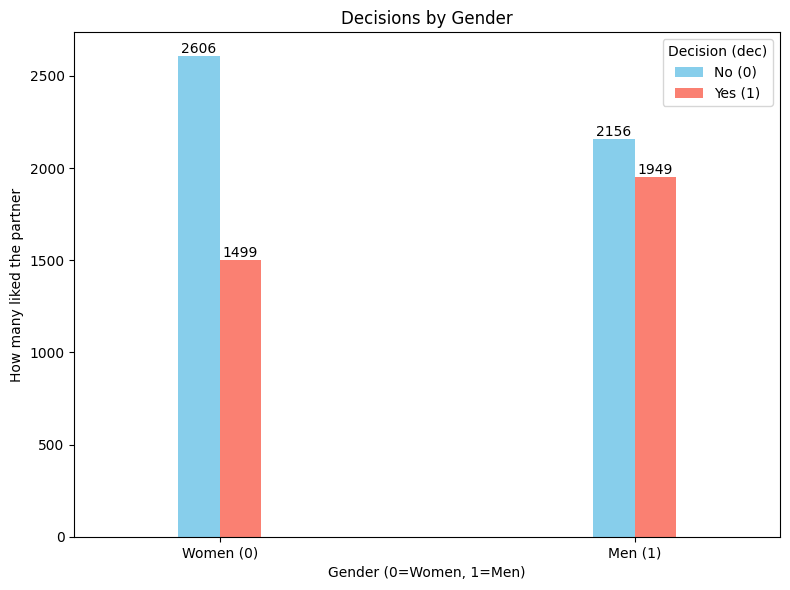

In [52]:
grouped_counts = df.groupby('gender')['dec'].value_counts().unstack(fill_value=0)

ax = grouped_counts.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'salmon'], width=0.2)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
cplt.txylabel('Decisions by Gender', 'Gender (0=Women, 1=Men)', 'How many liked the partner')
cplt.xticks(ticks=[0, 1], labels=['Women (0)', 'Men (1)'], rotation=0)
cplt.legend(title='Decision (dec)', labels=['No (0)', 'Yes (1)']).tight_layout().show()

The data reveals that female respondents showed a higher proportion of negative responses ('No') and lower proportion of positive responses ('Yes') compared to their male partners. Based on this pattern, we'll perform stratified sampling across both _dec_ (decision) and _gender_ variables to ensure balanced representation.

In [53]:
df['dec_by_gender'] = df[['dec', 'gender']].astype(str).agg('_'.join, axis=1)

In [54]:
X = df.drop(columns=["dec", "dec_by_gender"], axis=1)
y = df["dec"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df["dec_by_gender"], random_state=RANDOM_STATE)

Temporarily hide the original dataframe so we don't accidentally refer to it:

In [55]:
df_hide_me, X_hide_me, y_hide_me = df.copy(), X.copy(), y.copy()
del df
del X
del y

## Impute missing data

### Interests columns

Inspect the number of missing values and the min-max range of the existing values:

In [56]:
X_train[cols_interests].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6568 entries, 4504 to 50
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   music     6568 non-null   float64
 1   exercise  6568 non-null   float64
 2   dining    6568 non-null   float64
 3   tv        6568 non-null   float64
 4   tvsports  6568 non-null   float64
 5   sports    6568 non-null   float64
 6   shopping  6568 non-null   float64
 7   yoga      6568 non-null   float64
 8   gaming    6568 non-null   float64
 9   reading   6568 non-null   float64
 10  theater   6568 non-null   float64
 11  hiking    6568 non-null   float64
 12  art       6568 non-null   float64
 13  museums   6568 non-null   float64
 14  clubbing  6568 non-null   float64
 15  concerts  6568 non-null   float64
 16  movies    6568 non-null   float64
dtypes: float64(17)
memory usage: 923.6 KB


In [57]:
X_train[cols_interests].custom.describe()

,music,exercise,dining,tv,tvsports,sports,shopping,yoga,gaming,reading,theater,hiking,art,museums,clubbing,concerts,movies
count,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00
mean,7.86,6.27,7.79,5.31,4.59,6.42,5.65,4.35,3.89,7.67,6.80,5.74,6.72,7.00,5.74,6.84,7.92
std,1.79,2.42,1.76,2.53,2.81,2.63,2.61,2.72,2.64,2.01,2.24,2.56,2.27,2.05,2.49,2.16,1.72
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,14.00,13.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
median,8.00,7.00,8.00,6.00,4.00,7.00,6.00,4.00,3.00,8.00,7.00,6.00,7.00,7.00,6.00,7.00,8.00


Some features have values of 0, despite the key document specifying a range of 1-10. We need to determine whether this means respondents skipped these sections entirely or if they deliberately used 0 to express extremely low interest.

In [58]:
X_train[(X_train.yoga) == 0][['iid'] + cols_interests]

,iid,music,exercise,dining,tv,tvsports,sports,shopping,yoga,gaming,reading,theater,hiking,art,museums,clubbing,concerts,movies
6378,413,6.0,5.0,7.0,8.0,7.0,6.0,7.0,0.0,5.0,6.0,6.0,5.0,3.0,5.0,4.0,6.0,9.0
6393,414,1.0,9.0,5.0,7.0,5.0,10.0,2.0,0.0,5.0,8.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
6387,413,6.0,5.0,7.0,8.0,7.0,6.0,7.0,0.0,5.0,6.0,6.0,5.0,3.0,5.0,4.0,6.0,9.0
6404,414,1.0,9.0,5.0,7.0,5.0,10.0,2.0,0.0,5.0,8.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
6401,414,1.0,9.0,5.0,7.0,5.0,10.0,2.0,0.0,5.0,8.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
6389,413,6.0,5.0,7.0,8.0,7.0,6.0,7.0,0.0,5.0,6.0,6.0,5.0,3.0,5.0,4.0,6.0,9.0
6403,414,1.0,9.0,5.0,7.0,5.0,10.0,2.0,0.0,5.0,8.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
6394,414,1.0,9.0,5.0,7.0,5.0,10.0,2.0,0.0,5.0,8.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
6384,413,6.0,5.0,7.0,8.0,7.0,6.0,7.0,0.0,5.0,6.0,6.0,5.0,3.0,5.0,4.0,6.0,9.0
6398,414,1.0,9.0,5.0,7.0,5.0,10.0,2.0,0.0,5.0,8.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


Seems like 0 is used to indicate a low interest, therefore we will replace the 0s with 1 (minimum interest) to maintain data consistency and avoiding skewing analyses.

In [59]:
X_train[cols_interests] = X_train[cols_interests].replace(0, 1)
X_test[cols_interests]  = X_test[cols_interests].replace(0, 1)

X_train[cols_interests_o] = X_train[cols_interests_o].replace(0, 1)
X_test[cols_interests_o]  = X_test[cols_interests_o].replace(0, 1)

### Age by gender

inspect number of missing values and the median age by gender:

In [60]:
cols_median_by_gender =  ['age', 'age_o']
X_train[cols_median_by_gender].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6568 entries, 4504 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     6542 non-null   float64
 1   age_o   6542 non-null   float64
dtypes: float64(2)
memory usage: 153.9 KB


In [61]:
X_train.groupby('gender')[['age']].median()

,age
gender,
0,26.0
1,27.0


Age values are imputed using gender-specific medians to preserves gender-specific age patterns in the data.

🧡MII add link

Function `impute_columns_by_gender` imputes missing or specific placeholder values (defined by old_value) in multiple columns of training (X_train) and test (X_test) datasets based on the gender of the individuals. 

In [62]:
X_train, X_test = impute_columns_by_gender(X_train, X_test, cols_median_by_gender, old_value=None)

### Race columns (How important is the race of your partner)

Inspect the number of missing values and the min-max range of the existing values:

In [63]:
X_train[['imprace', 'imprace_o']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6568 entries, 4504 to 50
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   imprace    6568 non-null   float64
 1   imprace_o  6568 non-null   float64
dtypes: float64(2)
memory usage: 153.9 KB


In [64]:
X_train[['imprace', 'imprace_o']].custom.describe()

,imprace,imprace_o
count,6568.00,6568.00
mean,3.78,3.77
std,2.84,2.84
min,0.00,0.00
max,10.00,10.00
median,3.00,3.00


Since there are no missing values but the minimal value is 0, we will assume that the respondents answered with 0 to assign minimal importance on the partner's race.

In [65]:
cols = ['imprace', 'imprace_o']
for col in cols:
    median = X_train[col].median()
    X_train[col] = X_train[col].replace(0, median)
    X_test[col] = X_test[col].replace(0, median)

### Date columns (How often do you go out on a date)

In [66]:
cols = ['date', 'date_o']
X_train[cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6568 entries, 4504 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6557 non-null   float64
 1   date_o  6552 non-null   float64
dtypes: float64(2)
memory usage: 153.9 KB


In [67]:
X_train[cols].custom.describe()

,date,date_o
count,6557.00,6552.00
mean,5.01,5.00
std,1.44,1.45
min,1.00,1.00
max,7.00,7.00
median,5.00,5.00


In [68]:
columns =  ['date', 'date_o']
for col in columns:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val) # Fill NA values
    X_test[col] = X_test[col].fillna(median_val) # Fill NA values

### Questionnaire

Check remaining missing data:

In [69]:
X_train.isna().sum()[X_train.isna().sum() > 0]

field_cd        16
fun1_1           8
amb1_1          16
shar1_1         32
attr4_1       1448
sinc4_1       1448
intel4_1      1448
fun4_1        1448
amb4_1        1448
shar4_1       1464
amb2_1           8
shar2_1          8
attr3_1         21
sinc3_1         21
fun3_1          21
intel3_1        21
amb3_1          21
attr5_1       2697
sinc5_1       2697
intel5_1      2697
fun5_1        2697
amb5_1        2697
fun1_1_o         9
amb1_1_o        18
shar1_1_o       37
amb2_1_o         9
shar2_1_o        9
attr3_1_o       24
sinc3_1_o       24
intel3_1_o      24
fun3_1_o        24
amb3_1_o        24
attr4_1_o     1448
sinc4_1_o     1448
intel4_1_o    1448
fun4_1_o      1448
amb4_1_o      1448
shar4_1_o     1467
attr5_1_o     2700
sinc5_1_o     2700
intel5_1_o    2700
fun5_1_o      2700
amb5_1_o      2700
dtype: int64

All remaining columns with missing data are the questionnaire columns.

In [70]:
X_train[cols_questionnaire1 + cols_questionnaire3].custom.describe()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr3_1,sinc3_1,intel3_1,fun3_1,amb3_1
count,6568.00,6568.00,6568.00,6560.00,6552.00,6536.00,6547.00,6547.00,6547.00,6547.00,6547.00
mean,22.60,17.34,20.28,17.42,10.69,11.82,7.09,8.29,8.41,7.70,7.58
std,12.63,7.03,6.83,6.11,6.07,6.36,1.40,1.42,1.08,1.57,1.79
min,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2.00,3.00,2.00,2.00
max,100.00,60.00,50.00,50.00,53.00,30.00,10.00,10.00,10.00,10.00,10.00
median,20.00,18.18,20.00,18.00,10.00,10.64,7.00,8.00,8.00,8.00,8.00


Inspecting the values we can see that some questions have a higher max and mean values. This happens because of a difference in the scale. Some wave of participants were asked to answer on a scale from 1 to 10. Other waves were asked to distribute 100 points among the questions.

![questionnaire_max_values.png](images/questionnaire_max_values.png)

Since each question group must total exactly 100 points, we can't simply fill in missing values with the median. Instead, we should calculate the missing value by subtracting the sum of known responses from 100. This ensures we maintain the required 100-point total for each group.

To achieve this we will calculate the sum and count of missing values for each questionnaire group. When a group has between 1-5 missing values (because the number of question is 6, the 6th answer may contain 100 points) and the existing values sum to 100, it fills the missing values with zeros, effectively distributing the questionnaire responses while preserving the total sum constraint.

🧡MII add link to function

In [71]:
# Impute 0 because so that the sum of all answers will be 100
X_train, X_test = questionnaire_impute_0(X_train, X_test, cols_questionnaire1, cols_questionnaire1_o, 'quest1')
X_train, X_test = questionnaire_impute_0(X_train, X_test, cols_questionnaire2, cols_questionnaire2_o, 'quest2')
X_train, X_test = questionnaire_impute_0(X_train, X_test, cols_questionnaire3, cols_questionnaire3_o, 'quest3', max_nan=4)
X_train, X_test = questionnaire_impute_0(X_train, X_test, cols_questionnaire4, cols_questionnaire4_o, 'quest4')
X_train, X_test = questionnaire_impute_0(X_train, X_test, cols_questionnaire5, cols_questionnaire5_o, 'quest5', max_nan=4)

Are there any remaining missing values?

In [72]:
X_train[cols_questionnaire3 + cols_questionnaire3_o].isna().sum()

attr3_1       21
sinc3_1       21
intel3_1      21
fun3_1        21
amb3_1        21
attr3_1_o     24
sinc3_1_o     24
intel3_1_o    24
fun3_1_o      24
amb3_1_o      24
dtype: int64

Yes, impute with the median value by gender:

In [73]:
X_train, X_test = impute_columns_by_gender(X_train, X_test, cols_questionnaire, old_value=None)
X_train, X_test = impute_columns_by_gender(X_train, X_test, cols_questionnaire_o, old_value=None)

## Normalize values

The following sections normalize various categorical and numerical variables to make them more suitable for analysis and modeling.

### Interest columns

In [74]:
X_train[cols_interests].custom.describe()

,music,exercise,dining,tv,tvsports,sports,shopping,yoga,gaming,reading,theater,hiking,art,museums,clubbing,concerts,movies
count,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00,6568.00
mean,7.86,6.27,7.79,5.31,4.59,6.42,5.65,4.35,3.89,7.67,6.80,5.74,6.73,7.00,5.75,6.84,7.93
std,1.79,2.42,1.76,2.53,2.81,2.63,2.61,2.71,2.63,2.01,2.24,2.55,2.26,2.04,2.49,2.15,1.71
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,14.00,13.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
median,8.00,7.00,8.00,6.00,4.00,7.00,6.00,4.00,3.00,8.00,7.00,6.00,7.00,7.00,6.00,7.00,8.00


Although the rating scale should ranged from 1 to 10, some participants entered values above 10. We interpret these responses as attempts to express extremely high interest. To maintain consistency with our scale's maximum value, we adjusted these responses down to 10.

In [75]:
replacement_dict = {
    1: 1, 
    2: 2, 
    3: 3, 
    4: 4, 
    5: 5, 
    6: 6, 
    7: 7, 
    8: 8, 
    9: 9, 
    10: 10,
    13: 10,
    14: 10}

X_train[cols_interests + cols_interests_o] = X_train[cols_interests + cols_interests_o].apply(lambda col: col.map(replacement_dict))
X_test[cols_interests + cols_interests_o]  = X_test[cols_interests + cols_interests_o].apply(lambda col: col.map(replacement_dict))

### Dating and going out frequency (_date_, _go_out_)

This section normalizes columns related to dating frequency and going out frequency. 

The current values are:

In general, how frequently do you go on dates? 
- Several times a week=1
- Twice a week=2
- Once a week=3
- Twice a month=4
- Once a month=5
- Several times a year=6
- Almost never=7

We will map the values to represent approximate number of times per year:
- 1 → 156 (≈3 times per week)
- 2 → 104 (≈2 times per week)
- 3 → 52 (weekly)
- 4 → 24 (bi-weekly)
- 5 → 12 (monthly)
- 6 → 6 (bi-monthly)
- 7 → 2 (rarely)

In [76]:
replacement_dict = {
    1: 156, 
    2: 104, 
    3: 52, 
    4: 24, 
    5: 12, 
    6: 6, 
    7: 2
}

cols = ["date", "date_o", "go_out", "go_out_o"]
X_train[cols] = X_train[cols].apply(lambda col: col.map(replacement_dict))
X_test[cols] = X_test[cols].apply(lambda col: col.map(replacement_dict))

### Importance of race and religion (_imprace_, _imprelig_)

This section groups the importance of race and religion ratings into three categories (1, 2, 3) instead of the original 1-10 scale:

In [77]:
replacement_dict = {
    1: 1, 2: 1, 3: 1,  # Low importance
    4: 2, 5: 2, 6: 2,  # Medium importance
    7: 3, 8: 3, 9: 3, 10: 3  # High importance
}

cols = ['imprace', 'imprace_o', 'imprelig', 'imprelig_o']
X_train[cols] = X_train[cols].apply(lambda col: col.map(replacement_dict))
X_test[cols]  = X_test[cols].apply(lambda col: col.map(replacement_dict))

### Goal of participating (_goal_/_goal_o_)

The original values are:

What is your primary goal in participating in this event? 
- Seemed like a fun night out=1
- To meet new people=2
- To get a date=3
- Looking for a serious relationship=4
- To say I did it=5
- Other=6

We will simplify dating goals into three main categories:
- 1 - I just want to have fun
- 2 - I'm serious about finding friends or a date 
- 6 - Other

In [78]:
replacement_dict = {
    1: 1,  # Category 1 (I just want to have fun)
    2: 2, 3: 2, 4: 2,  # Category 2 (I'm serious about finding friends or a date )
    5: 1,  # Category 1
    6: 99  # Category 6 (Other - kept separate)
}

cols = ['goal', 'goal_o']
X_train[cols] = X_train[cols].apply(lambda col: col.map(replacement_dict))
X_test[cols]  = X_test[cols].apply(lambda col: col.map(replacement_dict))

## Feature engineering - add equality/difference columns

### Equality columns

Creates binary features (0/1) by comparing if values match between pairs of subject/partner characteristics. For example, if two users are from the same city, city_eq would be 1, otherwise 0.

In [79]:
cols = ['goal'] + ['race', 'imprace', 'imprelig'] + ['field'] + ['city', 'state_or_country']
X_train = create_equality_features(X_train, cols)
X_test = create_equality_features(X_test, cols)

### Difference columns

Create a new column with the numerical gap between 'goal' values for pairs by subtracting them (goal - goal_o). 

In [80]:
cols = ['goal']

for col in cols:
    X_train[f'{col}_diff'] = (X_train[col] - X_train[f'{col}_o'])
    X_test[f'{col}_diff']  = (X_test[col] - X_test[f'{col}_o'])

## Delete columns/rows

### Drop columns for which we calculated equality

In [81]:
# 💛 MII do not delete career and career_o, we have cleaned it, may be useful
cols_to_drop = []
cols_to_drop = cols_to_drop + ['field', 'field_o', "career", "career_o"]
cols_to_drop = cols_to_drop + ['from', 'undergra', 'city', 'city_o', 'city_eq', 'state_or_country', 'state_or_country_o']

X_train = X_train.drop(columns=cols_to_drop, axis=1, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, axis=1, errors='ignore')

### Delete other columns

In [82]:
cols_to_drop = ['iid', 'pid', 'wave', 'field_cd', 'gender_o', 'dec_o', 'samerace']
X_train = X_train.drop(columns=cols_to_drop, axis=1, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, axis=1, errors='ignore')

## Apply scaling of the entire dataframe

In [83]:
scaler = MaxAbsScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), index = X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(scaler.fit_transform(X_test),  index = X_test.index,  columns=X_test.columns)   

## Choose a metric

In developing a machine learning model for a dating app, our goal is to accurately predict good matches between registered users based on their questionnaire responses. To ensure a positive user experience, we must prioritize **minimizing false positives**, where the model might suggest a match that isn't actually compatible. This approach aligns with maximizing **precision** - the proportion of predicted matches that are genuinely good matches. 

However, maximizing precision alone could result in very low recall, meaning we might overlook many potential good matches. To address this, we aim to establish a balanced approach that maintains high precision while retaining enough recall to avoid missing too many viable connections. To achieve this balance, we will implement a custom weighted metric that assigns 70% weight to precision and 30% to recall, guiding the model to focus on accurate match predictions while also allowing for a reasonable level of inclusivity in recommendations. This approach aligns with our objective of quality over quantity, but not at the expense of completely disregarding potentially good matches.

### Define a custom weighted metric

The default F1 score assigns equal weights to precision and recall. In order to achieve our goal of having 70% weight on the precision, we will define a **weighted F1-score** (also called the $ F_{\beta} $-score).

To calculate it, we can use the following formula:

$$
F_{\text{weighted}} = \frac{(1 + \beta^2) \times \text{Precision} \times \text{Recall}}{(\beta^2 \times \text{Precision}) + \text{Recall}}
$$

where:
- $ \beta $ is a parameter that represents the weight given to recall relative to precision. A smaller $ \beta $ (less than 1) puts more weight on precision, while a larger $ \beta $ (greater than 1) favors recall.

### Determine $ \beta $ Based on the Precision-Recall Balance

We need to calculate $ \beta $ such that precision gets a weight of 0.7 and recall gets a weight of 0.3. We can achieve this using the formula:

   $$
   \beta = \sqrt{\frac{1 - \text{Precision weight}}{\text{Precision weight}}} = \sqrt{\frac{1 - 0.7}{0.7}} \approx 0.55
   $$

## ➡️Test Optuna

#### Imports

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, make_scorer
import time
from typing import Tuple, Dict, Callable
from functools import partial
from functools import partial, update_wrapper

#### Helpers

In [ ]:
def custom_metric(y_true, y_pred):
    """
    Custom metric that combines precision and recall with a fixed weight.
    """
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    BETA = 0.55
    f_weighted = (1 + BETA**2) * (prec * rec) / ((BETA**2 * prec) + rec)

    return f_weighted

def get_metrics(y_true, y_pred, custom_scorer):
    """Calculate all relevant metrics"""
    return {
        'f1_weighted': custom_scorer(y_true, y_pred),
        'f1':          f1_score(y_true, y_pred),
        'precision':   precision_score(y_true, y_pred),
        'recall':      recall_score(y_true, y_pred)
    }

#### Objective

In [ ]:
def objective(trial, X_train, y_train, custom_scorer):
    """Optuna objective function using custom metric"""
    params = {
        'n_estimators':      trial.suggest_categorical('n_estimators', [100, 200, 300]),
        # 'max_depth':         trial.suggest_categorical('max_depth', [None]),
        # 'min_samples_split': trial.suggest_categorical('min_samples_split', [2]),
        # 'min_samples_leaf':  trial.suggest_categorical('min_samples_leaf', [1]),
        # 'max_features':      trial.suggest_categorical('max_features', ['sqrt']) # 'log2'
    }
    
    clf = RandomForestClassifier(**params, random_state=RANDOM_STATE, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=custom_scorer)
    return scores.mean()

#### Train and evaluate

In [84]:
N_TRIALS = 10

In [ ]:
np.random.seed(RANDOM_STATE)

def train_and_evaluate(_X_train, _X_test, _y_train, _y_test, precision_weight: float = 0.7):
    X_train, X_test, y_train, y_test = _X_train.copy(), _X_test.copy(), _y_train.copy(), _y_test.copy()
    
    X_train_scaled = X_train
    X_test_scaled = X_test
    
    # Define custom scorer callable
    def custom_scorer_callable(estimator, X, y):
        y_pred = estimator.predict(X)
        return custom_metric(y, y_pred)
    
    results = {
        'optuna': {'train': {}, 'test': {}, 'training_time': None}
    }
   
    # Optuna optimization
    print("\nOptimizing with Optuna...")
    optuna_start_time = time.time()
    sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)  # Set seed for the sampler
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(trial, X_train_scaled, y_train, custom_scorer_callable), n_trials=N_TRIALS)
    
    # Train final model with best parameters
    best_model = RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE, n_jobs=-1)
    best_model.fit(X_train_scaled, y_train)
    results['optuna']['training_time'] = time.time() - optuna_start_time
    
    # Get Optuna predictions and metrics
    y_train_pred_optuna = best_model.predict(X_train_scaled)
    y_test_pred_optuna = best_model.predict(X_test_scaled)
    results['optuna']['train'] = get_metrics(y_train, y_train_pred_optuna, custom_metric)
    results['optuna']['test'] = get_metrics(y_test, y_test_pred_optuna, custom_metric)
    
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Optuna Train': [results['optuna']['train']['custom_score'], results['optuna']['train']['f1'], results['optuna']['train']['precision'], results['optuna']['train']['recall'], results['optuna']['training_time']],
        'Optuna Test': [results['optuna']['test']['custom_score'], results['optuna']['test']['f1'], results['optuna']['test']['precision'], results['optuna']['test']['recall'], '-']
    }, index=['Custom Score', 'F1 Score', 'Precision', 'Recall', 'Training Time (s)'])
    
    print(f"\nUsing custom metric (precision_weight={precision_weight})")
    print("\nBest Optuna parameters:", study.best_params)
    print("\nMetrics Comparison:")
    print(comparison.round(4))
    
    # Detailed classification reports
  
    print("\nOptuna Model - Test Set Classification Report:")
    print(classification_report(y_test, y_test_pred_optuna))
    
    return best_model, scaler, study #study.best_params

In [ ]:
best_model, scaler, study = train_and_evaluate(X_train, X_test, y_train, y_test, precision_weight=0.7)

In [ ]:
print("Best model (optuna)", best_model.get_params())

In [ ]:
print("Best params: ", study.best_params)

## 💛Choose a model

First, we will train several base models using their default hyperparameters. The performance of these models will be evaluated using cross validation with the F-beta score as the metric.

Based on the F-beta score from cross-validation, the top 5 models will be selected for further fine-tuning. These models will be trained with an expanded set of hyperparameters to improve their performance.

Among the fine-tuned models, the one with the highest F-beta score will be chosen as the final model. This model will then be used to make predictions (`y_pred`) on the test dataset.

### Train base models

#### Define base models

In [85]:
log_reg_param_grid = {"model": [LogisticRegression(random_state=RANDOM_STATE)], "model__max_iter": [1000]}
hgbc_param_grid    = {"model": [HistGradientBoostingClassifier(random_state=RANDOM_STATE)]}
rf_param_grid      = {"model": [RandomForestClassifier(random_state=RANDOM_STATE)]}
svc_param_grid     = {"model": [SVC(random_state=RANDOM_STATE)]}
knn_param_grid     = {"model": [KNeighborsClassifier()]}
gb_param_grid      = {"model": [GradientBoostingClassifier(random_state=RANDOM_STATE)]}
dt_param_grid      = {"model": [DecisionTreeClassifier(random_state=RANDOM_STATE)]}
pac_param_grid     = {"model": [PassiveAggressiveClassifier(random_state=RANDOM_STATE)]}
lda_param_grid     = {"model": [LinearDiscriminantAnalysis()]}
xgb_param_grid     = {"model": [XGBClassifier(objective="binary:logistic", random_state=RANDOM_STATE)]}
perceptron_param_grid = {"model": [Perceptron(random_state=RANDOM_STATE)]}

#### Define base parameter grid

In [86]:
param_grid_base = [
    {**log_reg_param_grid},
    {**rf_param_grid},
    {**xgb_param_grid},
    {**hgbc_param_grid},
    {**gb_param_grid},
    {**svc_param_grid},
    {**knn_param_grid},
    {**dt_param_grid},
    {**perceptron_param_grid},
    {**pac_param_grid},
    {**lda_param_grid},
]

#### Evaluate base models

In [87]:
print("Evaluating several base models: ")
results_base = evaluate_parameter_grid(param_grid_base, X_train, y_train)

Evaluating several base models: 
Evaluating combination 1/1: Weighted fbeta score: 0.5401 (from cache af99c4a36af029aa5413c8987d78d5b4)
Evaluating combination 1/1: Weighted fbeta score: 0.6419 (from cache 0c698364e7d3b873fd124ac7cc7fdd0d)
Evaluating combination 1/1: Weighted fbeta score: 0.6500 (from cache 524d96d1aa92eb64ae3bcf9803ebe31f)
Evaluating combination 1/1: Weighted fbeta score: 0.6564 (from cache 396b5d2c4b361f06330d6a7c9a4e8eb7)
Evaluating combination 1/1: Weighted fbeta score: 0.6248 (from cache 180869454fce5727450a365af6a2481a)
Evaluating combination 1/1: Weighted fbeta score: 0.5872 (from cache 581986bc09cafe0da4491a0a461edd90)
Evaluating combination 1/1: Weighted fbeta score: 0.5838 (from cache 349c15d5a9aee5616d05e96e791367ea)
Evaluating combination 1/1: Weighted fbeta score: 0.5443 (from cache c0cc3b4dc2a35a11d6ef5b840b702f05)
Evaluating combination 1/1: Weighted fbeta score: 0.3875 (from cache 0d74a43d730b306a6b2eb4169fc57fc8)
Evaluating combination 1/1: Weighted fbe

### Select and hypertune top 5 models

#### Select top 5 models

In [88]:
print("Top 5 base models: ")
top_results_base = display_top_models(results_base, X_train.shape[1], top_k = 5, sort_by = 'weighted_fbeta')

Top 5 base models: 
Rank 1/11 - Weighted Fbeta: 0.6564, Precision: 0.7052, Recall: 0.6924
Pipeline parameters: 
model: HistGradientBoostingClassifier, 
categorical_features: warn, class_weight: None, early_stopping: auto, interaction_cst: None, l2_regularization: 0.0, learning_rate: 0.1, loss: log_loss, max_bins: 255, max_depth: None, max_features: 1.0, max_iter: 100, max_leaf_nodes: 31, min_samples_leaf: 20, monotonic_cst: None, n_iter_no_change: 10, random_state: 42, scoring: loss, tol: 1e-07, validation_fraction: 0.1, verbose: 0, warm_start: False, 

Rank 2/11 - Weighted Fbeta: 0.6500, Precision: 0.6987, Recall: 0.6912
Pipeline parameters: 
model: XGBClassifier, 
objective: binary:logistic, base_score: None, booster: None, callbacks: None, colsample_bylevel: None, colsample_bynode: None, colsample_bytree: None, device: None, early_stopping_rounds: None, enable_categorical: False, eval_metric: None, feature_types: None, gamma: None, grow_policy: None, importance_type: None, interacti

#### Define the parameters to optimize

Function `load_model_params`, [defined in src/helpers.py](src/helpers.py) loads a JSON file, removes comments, and returns the parsed JSON object.

In [89]:
# Histogram-based Gradient Boosting Classifier
hdbc_param_grid = {
    "model": [HistGradientBoostingClassifier(random_state=RANDOM_STATE)],
    **load_model_params("src/model_params/hist_gradient_boosting_cls_full.json")
}

xgb_param_grid = {
    "model": [XGBClassifier(objective='binary:logistic', random_state=RANDOM_STATE)],
    **load_model_params("src/model_params/xgb_cls_full.json")
    # "model__booster": ["gbtree"],  # Type of booster to use

    # # Tree Booster Parameters (used in gbtree and dart boosters)
    # "model__eta":               [0.05, 0.1, 0.2, 0.25, 0.3],     # ,  # Learning rate (slower = more robust)
    # "model__max_depth":         [3, 10],      # default=6
    # "model__min_child_weight":  [5],       # default=1
    # "model__gamma":             [0],       # default=0
    # "model__subsample":         [1.0],     # default: 1
    # "model__colsample_bytree":  [1.0],     # default=1
    # "model__colsample_bylevel": [1.0],     # default=1
    # "model__colsample_bynode":  [1.0],     # default=1
    # "model__lambda":            [1],       # default=1, L2 regularization term on weights
    # "model__alpha":             [0],       # default=0, L1 regularization term on weights
    # "model__tree_method":       ["hist"],  # Method for building trees
    # "model__scale_pos_weight":  [1],  # default=1, Balance for positive classes
    # "model__objective":         ["binary:logistic"],  # Loss function for classification
    # "model__n_estimators":      [100]  # Number of boosting rounds
}

# Random Forest Classifier
rf_param_grid = {
    "model":                    [RandomForestClassifier(random_state=RANDOM_STATE)], 
    **load_model_params("src/model_params/random_forest_clf_full.json")
}

# Gradient Boosting Classifier - slow
gb_param_grid = {
    "model":                      [GradientBoostingClassifier(random_state=RANDOM_STATE)], 
    **load_model_params("src/model_params/gradient_boosting_clf_full.json")
}

# Support Vector Classifier
svc_param_grid = {
    "model": [SVC(random_state=RANDOM_STATE)], 
    **load_model_params("src/model_params/svc_clf_full.json")
}

#### Define parameter grid

In [90]:
param_grid_top5 = [
    # {** hdbc_param_grid}, # 💚MII uncomment!
    # {** xgb_param_grid}, 
    # {** rf_param_grid},
    {** gb_param_grid},  
    # {** svc_param_grid},
]

#### ➡️Try

In [91]:
%%skip
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

BETA = 0.55
def calculate_fbeta_score(y_true, y_pred):
    """
    Calculate weighted F1 score with more emphasis on precision by default giving 70% (beta=0.55) weight on precision.
    """
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    beta = BETA

    if not precision:
        return 0
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

param_grid = {
    "categorical_features": [None],         # ok [None, "warn"]
    "class_weight":         [None],         # ok [None, "balanced"]
    "l2_regularization":    [0.0],          # ok [0.0, 0.5],
    "learning_rate":        [0.6],          # ok [0.5, 0.6, 0.7],
    "max_depth":            [7],            # ok [6, 7, 8], 
    "max_features":         [0.9, 1.0],     # ok [0.4, 0.5, 0.6] default: 1.0
    "max_iter":             [300],          # ok [200, 300, 500],
    "min_samples_leaf":     [23],           # ok [20, 23, 25], default: 20
    "n_iter_no_change":     [10, 15, 20],   # ok [5, 10, 20], default: 10
    "validation_fraction":  [0.05],         # ok [0.04, 0.05, 0.06]
}

custom_scorer = make_scorer(calculate_fbeta_score)
scoring = {"precision": "precision_macro", "recall": "recall_macro", "weighted_fbeta": custom_scorer}

model = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
halving_search = HalvingGridSearchCV(
    model, param_grid, scoring=custom_scorer, cv=3, factor=3, verbose=1, n_jobs=-1,
)
halving_search.fit(X_train, y_train)

print()
print("Best score:", halving_search.best_score_)
for key, value in sorted(halving_search.best_params_.items()):
    print(f"{key}: {value}")

#### Evaluate the top 5 models

In [92]:
print("Tuning and evaluating top 5 models: ")
results_top5 = evaluate_parameter_grid(param_grid_top5, X_train, y_train)

Tuning and evaluating top 5 models: 
Evaluating combination 1/24: Weighted fbeta score: 0.3788 (from cache 8bb3ee6b3b8b63ad75120c1d660329ad)
Evaluating combination 2/24: Weighted fbeta score: 0.3275 (from cache 7f894f0f12a52ff7393c86ca56ed301a)
Evaluating combination 3/24: Weighted fbeta score: 0.4860 (from cache 577f33aecbdc24a55b10e0d604d9fcc8)
Evaluating combination 4/24: Weighted fbeta score: 0.5534 (from cache 8d19f65f166ec4bcfc1809b867a13714)
Evaluating combination 5/24: Weighted fbeta score: 0.5261 (from cache 523fe028533431fb2b08842030cd6764)
Evaluating combination 6/24: Weighted fbeta score: 0.5985 (from cache 6e713537d136fffa182428c246c93ae4)
Evaluating combination 7/24: Weighted fbeta score: 0.6164 (from cache d138bb7494dc6cc1a93da4d90003ab96)
Evaluating combination 8/24: Weighted fbeta score: 0.5974 (from cache d0b2f0aff78dbf3742610bd511311c27)
Evaluating combination 9/24: Weighted fbeta score: 0.6360 (from cache f79f4c0da5886e2a5a5df86b05cccc52)
Evaluating combination 10/2

In [93]:
print("Top 5 tuned models: ") 
top_results_top5 = display_top_models(results_top5, X_train.shape[1], top_k = 5, sort_by = 'weighted_fbeta')

Top 5 tuned models: 
Rank 1/24 - Weighted Fbeta: 0.6523, Precision: 0.7074, Recall: 0.6824
Pipeline parameters: 
model: GradientBoostingClassifier, 
ccp_alpha: 0.0, criterion: friedman_mse, init: None, learning_rate: 0.01, loss: log_loss, max_depth: 10, max_features: None, max_leaf_nodes: None, min_impurity_decrease: 0.0, min_samples_leaf: 1, min_samples_split: 2, min_weight_fraction_leaf: 0.0, n_estimators: 300, n_iter_no_change: None, random_state: 42, subsample: 0.5, tol: 0.0001, validation_fraction: 0.1, verbose: 0, warm_start: False, 

Rank 2/24 - Weighted Fbeta: 0.6498, Precision: 0.7086, Recall: 0.6780
Pipeline parameters: 
model: GradientBoostingClassifier, 
ccp_alpha: 0.0, criterion: friedman_mse, init: None, learning_rate: 0.01, loss: log_loss, max_depth: 7, max_features: None, max_leaf_nodes: None, min_impurity_decrease: 0.0, min_samples_leaf: 1, min_samples_split: 2, min_weight_fraction_leaf: 0.0, n_estimators: 300, n_iter_no_change: None, random_state: 42, subsample: 0.5, 

### ❤️[DELETEME] Tty the top 5 models on the test data

In [94]:
best_model_top5_0 = top_results_top5[0]['parameters']['model']
best_model_top5_1 = top_results_top5[1]['parameters']['model']
best_model_top5_2 = top_results_top5[2]['parameters']['model']
best_model_top5_3 = top_results_top5[3]['parameters']['model']

In [95]:
scores = predict_and_score(best_model_top5_0, X_test, y_test, 0.5, X_train.columns)
print_scores(scores)

F1:         0.5998
Fbeta:      0.6497
Precision:  0.7002
Recall:     0.5246
Accuracy:   0.7058


In [96]:
scores = predict_and_score(best_model_top5_1, X_test, y_test, 0.5, X_train.columns)
print_scores(scores)

F1:         0.5854
Fbeta:      0.6431
Precision:  0.7033
Recall:     0.5014
Accuracy:   0.7016


In [97]:
scores = predict_and_score(best_model_top5_2, X_test, y_test, 0.5, X_train.columns)

In [98]:
scores = predict_and_score(best_model_top5_3, X_test, y_test, 0.5, X_train.columns)
print_scores(scores)

F1:         0.5966
Fbeta:      0.6562
Precision:  0.7184
Recall:     0.5101
Accuracy:   0.7101


### Pick the top model from the tuned top 5

In [99]:
best_model_final = top_results_top5[0]['parameters']['model']

## [X_test] Feature selection using best model on X_test

💛MII Explain

### Feature selection using best model + X_train + f1 score + predict_proba

In [ ]:
stratify_var = pd.Series(y_train).astype(str) + '_' + pd.Series(X_train['gender'].astype(int)).astype(str)

In [ ]:
best_f1_based_on_predict_proba, best_predict_proba_threshold, selected_features = feature_selection_f1_based_cv(best_model, X_train, y_train, stratify_var, target_features=80, n_splits=5, random_state=RANDOM_STATE) 
print_info(f"Best predict_proba f1 score/threshold (X_train): {best_f1_based_on_predict_proba:.4f}/{best_predict_proba_threshold:.4f}")
print     (f"Best predict_proba f1 score/threshold (X_train): {best_f1_based_on_predict_proba:.4f}/{best_predict_proba_threshold:.4f}")
print     ("Best selected features: ", str(selected_features))

### Feature selection using best model + X_train + precision score + predict_proba

In [ ]:
%%skip
stratify_var = pd.Series(y_train).astype(str) + '_' + pd.Series(X_train['gender'].astype(int)).astype(str)

In [ ]:
%%skip
# 💛MII_REF09 cv=5
best_precision_based_on_predict_proba, best_predict_proba_threshold, selected_features = feature_selection_precision_based_cv(best_model, X_train, y_train, stratify_var, target_features=110, n_splits=5, random_state=RANDOM_STATE) 

In [ ]:
%%skip
print_info(f"Best predict_proba f1 score/threshold (X_train): {best_f1_based_on_predict_proba:.4f}/{best_predict_proba_threshold:.4f}")
print(f"Best predict_proba f1 score/threshold (X_train): {best_f1_based_on_predict_proba:.4f}/{best_predict_proba_threshold:.4f}")
print(f"Best selected features: ", str(selected_features))

## Predict on test data using best model, selected features and predict_proba threshold

In [ ]:
predict_and_score_on_test_data(best_model, X_test, y_test, best_predict_proba_threshold, selected_features)

In [100]:
scores = predict_and_score(best_model_final, X_test, y_test, 0.5, X_train.columns)
print_scores(scores)

F1:         0.5998
Fbeta:      0.6497
Precision:  0.7002
Recall:     0.5246
Accuracy:   0.7058


## 🧡ROC Curve [MII todo]

💛MII_MOD03 Display ROC Curve for base model, best model, maybe best model after feature selection. Example of ROC curve:

In [101]:
%%skip

# Generate a sample dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Calculate the predicted probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## 🧡Conclusion

## References

<div id="ref1">
    [1] Fisman, R., Iyengar, S. S., Kamenica, E., & Simonson, I. (2006). <a href="https://doi.org/10.1162/qjec.2006.121.2.673, [pdf](http://www.stat.columbia.edu/~gelman/stuff_for_blog/sheena.pdf" Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment</a>. The Quarterly Journal of Economics, 121(2), 673-697. 
</div>

<div id="ref2">
    [2] The original dataset and the key file: <a href="http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/">http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/</a>
</div>


## ❤️DELETEME

In [102]:
# ❤️MII DELETEME!
def print_info(msg, end=True, dst="automl_debug.log"):
    with open(dst, "a") as f:
        f.write(msg + ("\n" if end else ""))
        
now = datetime.now()
print_info(f"{now.hour:02}:{now.minute:02}:{now.second:02} - END")